# Ensemble Learning for a Hidden Markov Model

In this demo we are interested in estimating the state transition matrix $A$ of a hidden Markov model with states $s_0, s_1, \dots, s_T$ and observations $x_1, \dots, x_T$:

\begin{align*}
    s_t &\sim \mathcal{C}at(A s_{t-1})\\
    x_t &\sim \mathcal{C}at(B s_t)\\
\end{align*}

In generating our data we assume three states ("red", "green" and "blue"), and an inherent structure in the state transition matrix. More specifically, this structure entails that the system is unable to transition from "green" to "red"; from "blue" to "green", and from "red" to "blue". The goal of estimation to learn the hidden structure in the transition matrix from the data. 

In [1]:
using ForneyLab

n_samples = 100
A_data = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] # Transition model with inherent structure
B_data = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] # Observations with some uncertainty

s_0_data = [1.0, 0.0, 0.0] # Initial state

# Generate some data
s_data = Vector{Vector{Float64}}(n_samples)
x_data = Vector{Vector{Float64}}(n_samples)
s_t_min_data = s_0_data
for t = 1:n_samples
    a = A_data*s_t_min_data
    s_data[t] = sample(ProbabilityDistribution(Categorical, p=a./sum(a))) # Evolution model
    b = B_data*s_data[t]
    x_data[t] = sample(ProbabilityDistribution(Categorical, p=b./sum(b))) # Observation model
    
    s_t_min_data = s_data[t]
end
;

# Build

In our model we assume a relatively strong prior on the observation model, expressing the prior knowledge that we are most likely to observe the true state. On the other hand, we assume an uninformative prior on the state transition matrix, expressing no prior knowledge about transition probabilities and structure.

In [2]:
g = FactorGraph()

@RV A ~ Dirichlet(ones(3,3)) # Vague prior on transition model
@RV B ~ Dirichlet([10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0]) # Stronger prior on observation model
@RV s_0 ~ Categorical(1/3*ones(3))

s = Vector{Variable}(n_samples)
x = Vector{Variable}(n_samples)
s_t_min = s_0
for t = 1:n_samples
    @RV s[t] ~ Transition(s_t_min, A)
    @RV x[t] ~ Transition(s[t], B)
    
    s_t_min = s[t]
    
    placeholder(x[t], :x, index=t, dims=(3,))
end
;

# Schedule

We assume a recognition factorization

\begin{align*}
    q(s_0, s_1, \dots, s_T, A, B) = q(s_0, s_1, \dots, s_T)\times q(A)\times q(B)
\end{align*}

Under this factorization, ForneyLab automatically derives the ensemble learning algorithm (MacKay, 1997).

In [3]:
# Define the recognition factorization
q = RecognitionFactorization(A, B, [s_0; s], ids=[:A, :B, :S])

# Compile algorithm
algo = variationalAlgorithm(q)

# Construct free energy evaluation code
algo_F = freeEnergyAlgorithm(q)
;

# Infer

In [4]:
# Load algorithm
eval(parse(algo))
eval(parse(algo_F))

# Initial recognition distributions
marginals = Dict{Symbol, ProbabilityDistribution}(
    :A => vague(Dirichlet, (3,3)),
    :B => vague(Dirichlet, (3,3)))

# Initialize data
data = Dict(:x => x_data)
n_its = 20

# Run algorithm
F = Vector{Float64}(n_its)
for i = 1:n_its
    stepS!(data, marginals)
    stepB!(data, marginals)
    stepA!(data, marginals)

    F[i] = freeEnergy(data, marginals)
end
;

# Results

The results show that the variational algorithm converges, and that it accurately estimates the hidden state and the hidden structure in the transition matrix.

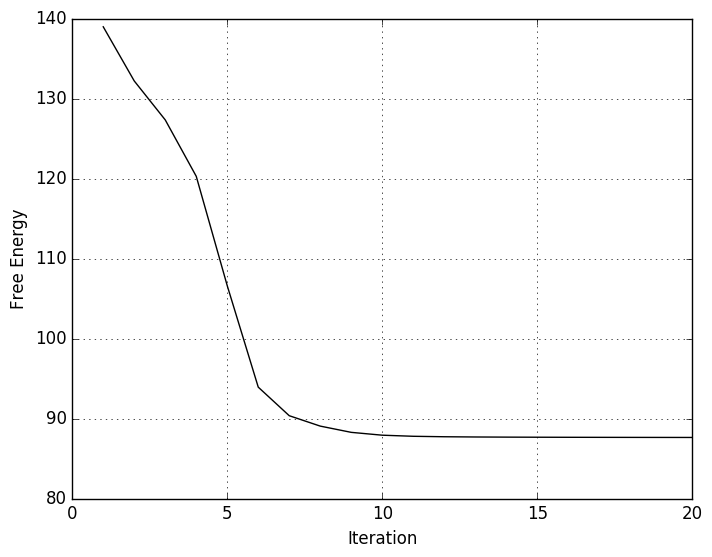

In [5]:
using PyPlot

# Plot free energy
plot(1:n_its, F, color="black")

grid("on")
xlabel("Iteration")
ylabel("Free Energy")
xlim(0,n_its);

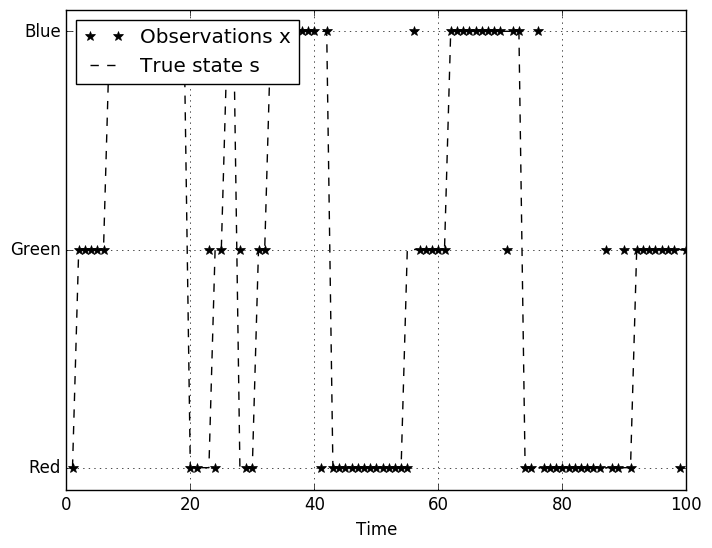

In [6]:
# Collect state estimates
x_obs = [findfirst(x_i.==1.0) for x_i in x_data]
s_true = [findfirst(s_i.==1.0) for s_i in s_data]

# Plot data and transitions
plot(1:n_samples, x_obs, "k*", label="Observations x", markersize=7)
plot(1:n_samples, s_true, "k--", label="True state s")

yticks([1.0, 2.0, 3.0], ["Red", "Green", "Blue"])
grid("on")
xlabel("Time")
legend(loc="upper left")
xlim(0,n_samples)
ylim(0.9,3.1);

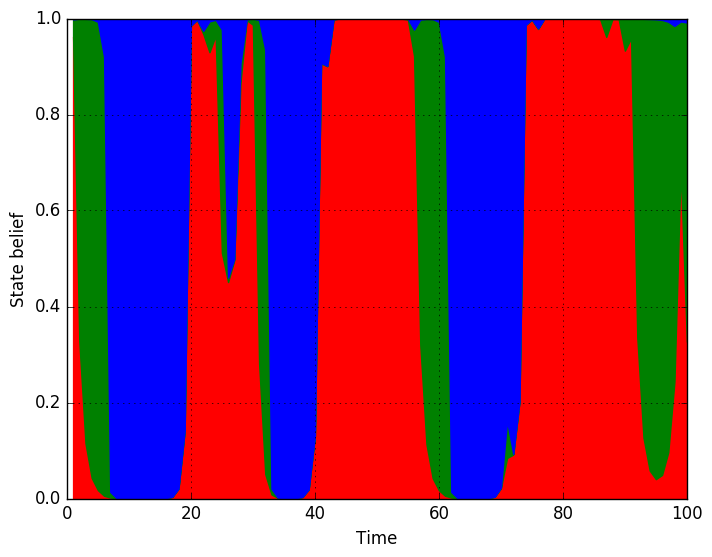

In [7]:
# Plot state estimate
m_s = [mean(marginals[:s_*t]) for t=1:n_samples]
m_s_1 = [m_s_t[1] for m_s_t in m_s]
m_s_2 = [m_s_t[2] for m_s_t in m_s]
m_s_3 = [m_s_t[3] for m_s_t in m_s]

fill_between(1:n_samples, zeros(n_samples), m_s_1, color="red")
fill_between(1:n_samples, m_s_1, m_s_1 + m_s_2, color="green")
fill_between(1:n_samples, m_s_1 + m_s_2, ones(n_samples), color="blue")

xlabel("Time")
ylabel("State belief")
grid("on")

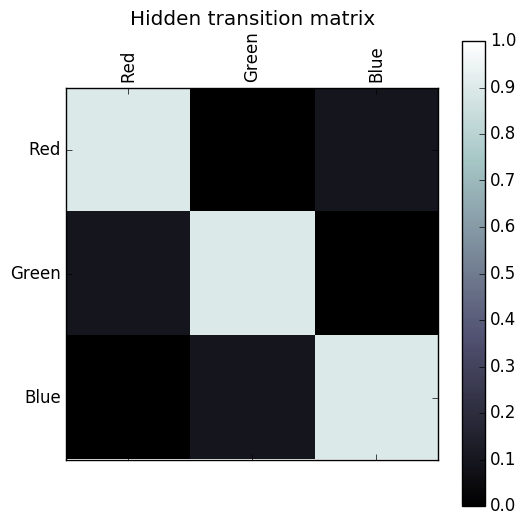

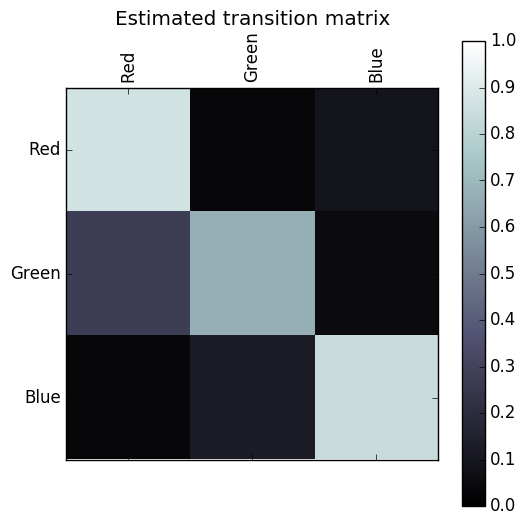

In [10]:
# Plot true and estimated transition matrix
PyPlot.plt[:matshow](A_data, cmap="bone", vmin=0.0, vmax=1.0)
ttl = title("Hidden transition matrix")
ttl[:set_position]([.5, 1.15])
yticks([0, 1, 2], ["Red", "Green", "Blue"])
xticks([0, 1, 2], ["Red", "Green", "Blue"], rotation="vertical")
colorbar()

PyPlot.plt[:matshow](mean(marginals[:A]), cmap="bone", vmin=0.0, vmax=1.0)
ttl = title("Estimated transition matrix")
ttl[:set_position]([.5, 1.15])
yticks([0, 1, 2], ["Red", "Green", "Blue"])
xticks([0, 1, 2], ["Red", "Green", "Blue"], rotation="vertical")
colorbar();